## Filtrado de EMG

=== MÉTRICAS EMG ===
RMS total (filtrada): 0.478 mV
PRD: 23.51 %
Correlación (x, x_filt): 0.979


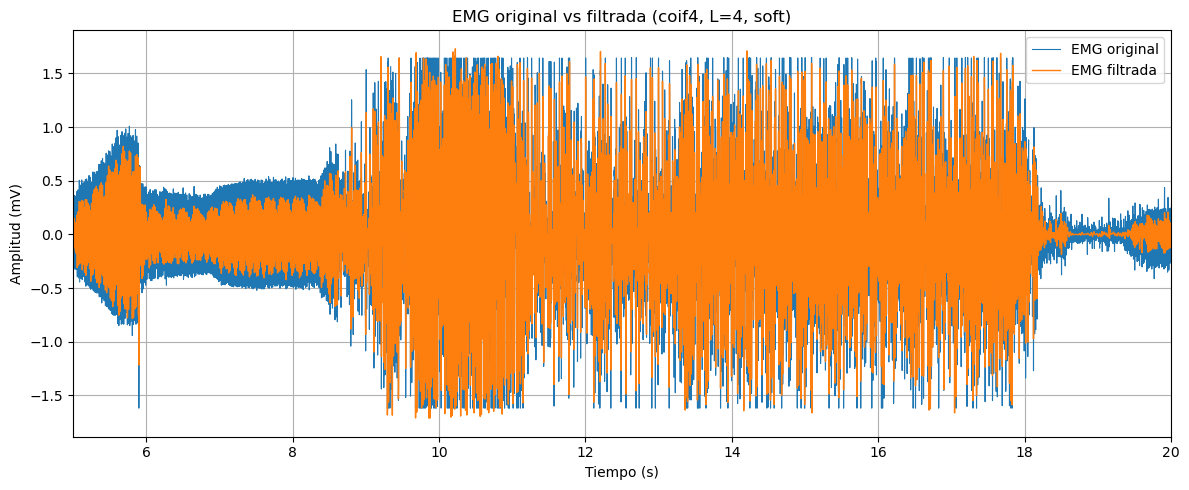

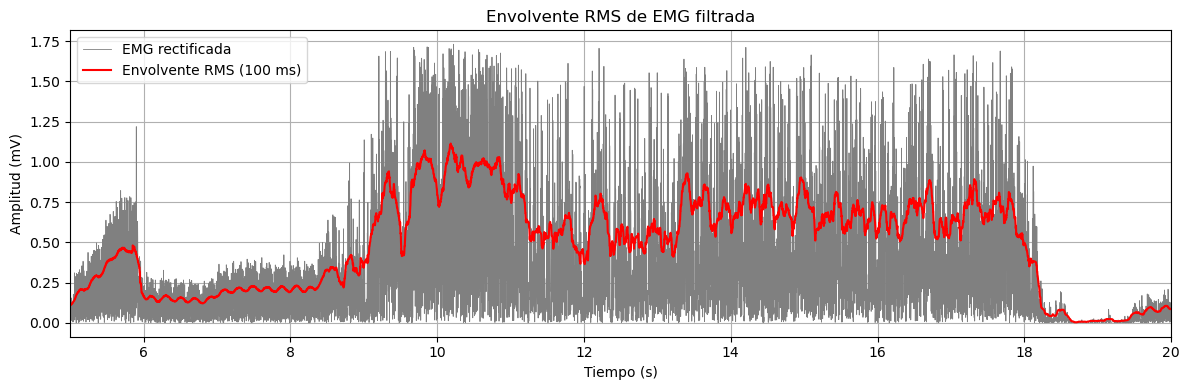

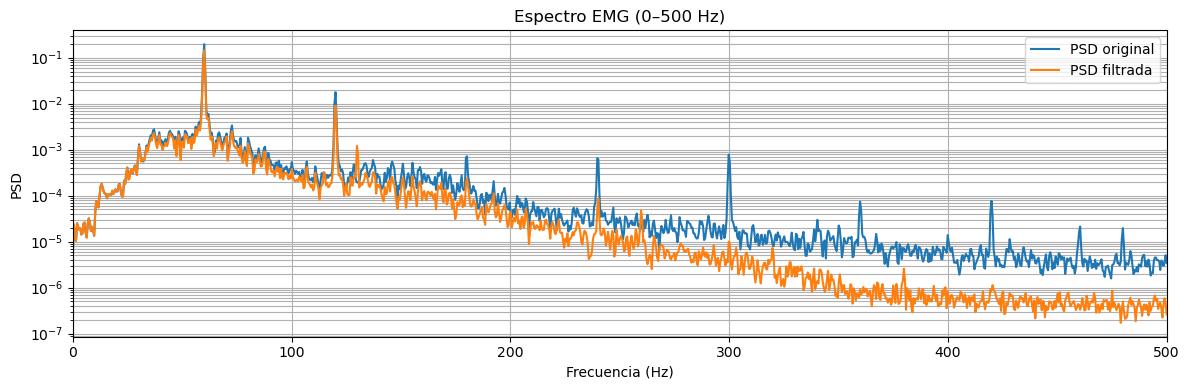

In [21]:

RUTA       = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 3 - EMG\Registro de datos\Posición 1\Toma3_Movimiento en contra_Posición1.txt"  # ruta del archivo
FS         = 1000.0     # Frecuencia de muestreo [Hz]
CANAL_IDX  = 5           # Columna del archivo donde está la señal EMG

# Parámetros del filtrado wavelet
WAVELET    = 'coif4'      # wavelet adecuado para EMG
LEVEL      = 4           # nivel de descomposición
TH_MODE    = 'soft'      # tipo de umbral

# Conversión de ADC si aplica (BITalino, etc.)
VCC, NBITS, GAIN = 3.3, 10, 1009.


import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import welch
from scipy.ndimage import uniform_filter1d


arr = np.loadtxt(RUTA)
x_adc = arr[:, CANAL_IDX].astype(float)

adc_max = 2**NBITS
emg_V = (x_adc/adc_max - 0.5) * (VCC/GAIN)
x = emg_V*1000.0 - np.mean(emg_V*1000.0)   # en milivoltios (mV), centrada
t = np.arange(len(x)) / FS


coeffs = pywt.wavedec(x, WAVELET, level=LEVEL, mode='symmetric')
sigma  = np.median(np.abs(coeffs[-1])) / 0.6745
lam    = sigma * np.sqrt(2*np.log(len(x)))

coeffs_filt = [coeffs[0]]  # coeficientes aproximados sin umbral
for c in coeffs[1:]:
    coeffs_filt.append(pywt.threshold(c, lam, mode=TH_MODE))

x_filt = pywt.waverec(coeffs_filt, WAVELET)[:len(x)]


# Rectificación
x_rect = np.abs(x_filt)

# Ventana de suavizado RMS (p.ej. 100 ms)
win_ms = 100
win_samples = int(win_ms * FS / 1000)
if win_samples % 2 == 0:
    win_samples += 1  # debe ser impar

# RMS con ventana móvil
x_sq = x_rect**2
x_rms = np.sqrt(uniform_filter1d(x_sq, size=win_samples))


RMS_total = np.sqrt(np.mean(x_filt**2))
PRD = 100 * np.linalg.norm(x - x_filt) / np.linalg.norm(x)
corr = np.corrcoef(x, x_filt)[0,1]

print("=== MÉTRICAS EMG ===")
print(f"RMS total (filtrada): {RMS_total:.3f} mV")
print(f"PRD: {PRD:.2f} %")
print(f"Correlación (x, x_filt): {corr:.3f}")


f, Pxx_o = welch(x, fs=FS, nperseg=2048)
_, Pxx_f = welch(x_filt, fs=FS, nperseg=2048)


# GRÁFICAS


# Señal original vs filtrada
plt.figure(figsize=(12,5))
plt.plot(t, x, label='EMG original', lw=0.8)
plt.plot(t, x_filt, label='EMG filtrada', lw=1.0)
plt.xlim(5,20)
plt.xlabel('Tiempo (s)'); plt.ylabel('Amplitud (mV)')
plt.title(f'EMG original vs filtrada ({WAVELET}, L={LEVEL}, {TH_MODE})')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Envolvente RMS
plt.figure(figsize=(12,4))
plt.plot(t, x_rect, color='gray', lw=0.6, label='EMG rectificada')
plt.plot(t, x_rms, color='red', lw=1.5, label='Envolvente RMS (100 ms)')
plt.xlim(5,20)
plt.xlabel('Tiempo (s)'); plt.ylabel('Amplitud (mV)')
plt.title('Envolvente RMS de EMG filtrada')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Espectro antes vs después
plt.figure(figsize=(12,4))
plt.semilogy(f, Pxx_o, label='PSD original')
plt.semilogy(f, Pxx_f, label='PSD filtrada')
plt.xlim(0,500)
plt.xlabel('Frecuencia (Hz)'); plt.ylabel('PSD')
plt.title('Espectro EMG (0–500 Hz)')
plt.legend(); plt.grid(True, which='both'); plt.tight_layout(); plt.show()


## Filtrado de ECG

=== MÉTRICAS DE VERIFICACIÓN ===
SNR_before : -8.23 dB
SNR_after  : 28.87 dB
SNR_gain   : +37.10 dB
RMSE       : 0.0080 mV
PRD        : 3.59 %
Corr(x,x_filt): 0.999

=== PRESERVACIÓN DE HR Y QRS ===
HR_raw : 128.3 bpm
HR_filt: 128.3 bpm
ΔHR     : +0.0 bpm
QRS_raw : 1.420 mV
QRS_filt: 1.406 mV
ΔQRS    : -0.98 %


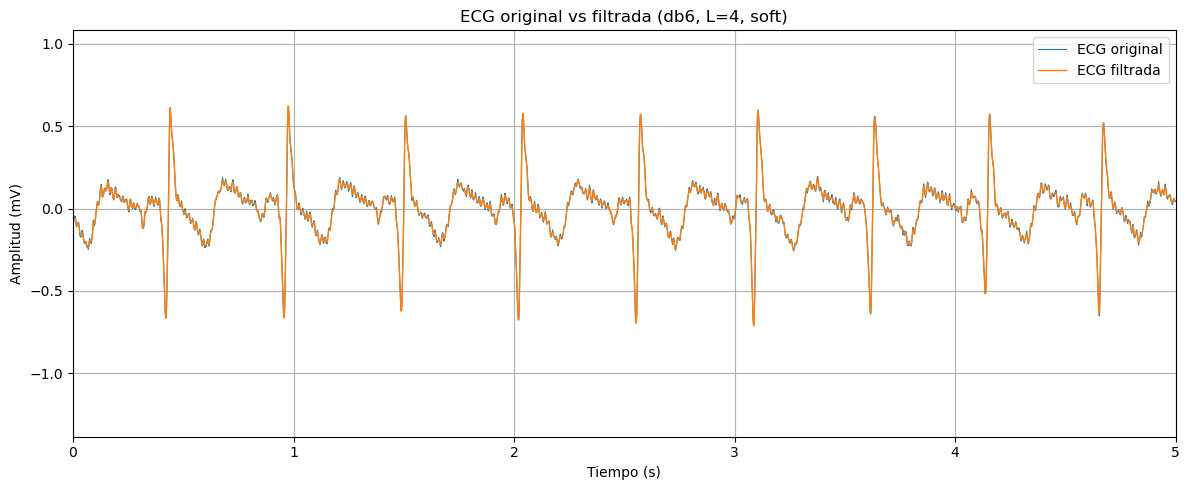

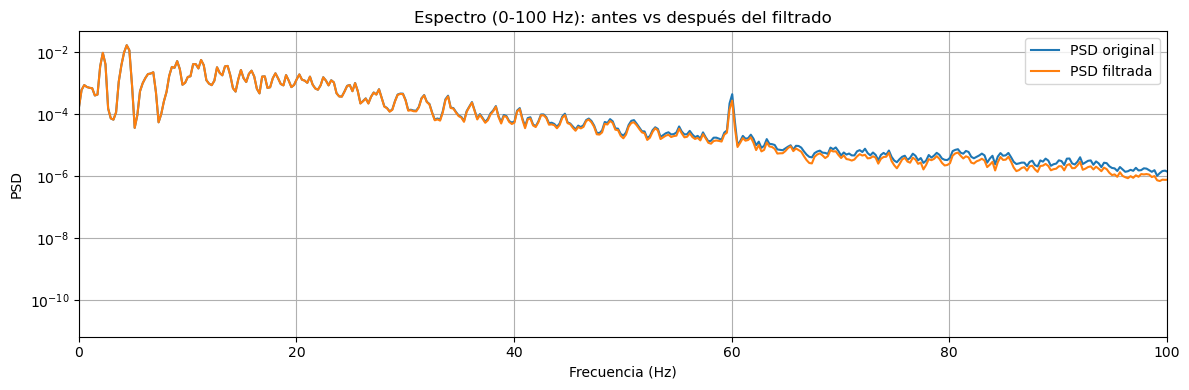

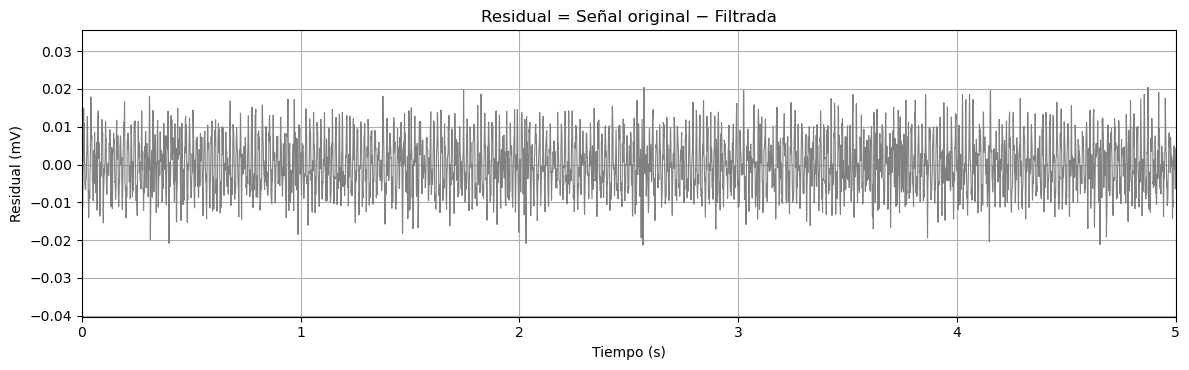

In [22]:
RUTA       = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 4 - ECG\Registro de datos\CG_D_T1.txt"
FS         = 1000.0      # Hz
CANAL_IDX  = 5           
WAVELET    = 'db6'
LEVEL      = 4
TH_MODE    = 'soft'

# BITalino ECG
VCC, NBITS, GAIN = 3.3, 10, 1100.0

# ===========================
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks
from scipy.ndimage import median_filter
import pywt

# ===========================
# LECTURA Y CONVERSIÓN

arr = np.loadtxt(RUTA)
x_adc = arr[:, CANAL_IDX].astype(float)

adc_max = 2**NBITS
ecg_V = (x_adc/adc_max - 0.5) * (VCC/GAIN)
x = ecg_V*1000.0 - np.mean(ecg_V*1000.0)   # mV centrada
t = np.arange(len(x))/FS

# ===========================
# DWT FILTRADO Y RECONSTRUCCIÓN

coeffs = pywt.wavedec(x, WAVELET, level=LEVEL, mode='symmetric')
sigma  = np.median(np.abs(coeffs[-1]))/0.6745
lam    = sigma*np.sqrt(2*np.log(len(x)))

# umbralado suave en detalles
coeffs_filtradas = [coeffs[0]]
for c in coeffs[1:]:
    coeffs_filtradas.append(pywt.threshold(c, lam, mode=TH_MODE))

x_filt = pywt.waverec(coeffs_filtradas, WAVELET)[:len(x)]

# ===========================
# VERIFICACIÓN CUANTITATIVA

# --- SNR, RMSE, PRD, correlación ---
win = int(max(5, (0.2*FS)//1)) | 1
baseline = median_filter(x, size=win)
noise_before = x - baseline
residual = x - x_filt

SNR_before = 10*np.log10(np.sum(baseline**2)/np.sum(noise_before**2))
SNR_after  = 10*np.log10(np.sum(x_filt**2)/np.sum(residual**2))
SNR_gain   = SNR_after - SNR_before
RMSE = np.sqrt(np.mean(residual**2))
PRD  = 100*np.linalg.norm(residual)/np.linalg.norm(x)
corr = np.corrcoef(x, x_filt)[0,1]

print("=== MÉTRICAS DE VERIFICACIÓN ===")
print(f"SNR_before : {SNR_before:.2f} dB")
print(f"SNR_after  : {SNR_after:.2f} dB")
print(f"SNR_gain   : {SNR_gain:+.2f} dB")
print(f"RMSE       : {RMSE:.4f} mV")
print(f"PRD        : {PRD:.2f} %")
print(f"Corr(x,x_filt): {corr:.3f}")

# HR y QRS
min_rr_s = 0.25
min_dist = int(min_rr_s*FS)
thr_raw  = np.percentile(x, 95)
thr_filt = np.percentile(x_filt, 95)

pks_raw,  _ = find_peaks(x, height=thr_raw, distance=min_dist)
pks_filt, _ = find_peaks(x_filt, height=thr_filt, distance=min_dist)

if len(pks_raw)>1 and len(pks_filt)>1:
    HR_raw  = 60.0/np.mean(np.diff(t[pks_raw]))
    HR_filt = 60.0/np.mean(np.diff(t[pks_filt]))
else:
    HR_raw = HR_filt = np.nan

QRSpp_raw  = np.mean([x[max(0,p-80):min(len(x),p+80)].max() - x[max(0,p-80):min(len(x),p+80)].min() for p in pks_raw])
QRSpp_filt = np.mean([x_filt[max(0,p-80):min(len(x),p+80)].max() - x_filt[max(0,p-80):min(len(x),p+80)].min() for p in pks_filt])
dHR  = HR_filt - HR_raw
dQRS = 100*(QRSpp_filt - QRSpp_raw)/QRSpp_raw

print("\n=== PRESERVACIÓN DE HR Y QRS ===")
print(f"HR_raw : {HR_raw:.1f} bpm")
print(f"HR_filt: {HR_filt:.1f} bpm")
print(f"ΔHR     : {dHR:+.1f} bpm")
print(f"QRS_raw : {QRSpp_raw:.3f} mV")
print(f"QRS_filt: {QRSpp_filt:.3f} mV")
print(f"ΔQRS    : {dQRS:+.2f} %")

# ===========================
# GRÁFICAS PARA VERIFICACIÓN

# 1. señal original vs filtrada
plt.figure(figsize=(12,5))
plt.plot(t, x, label='ECG original', lw=0.8)
plt.plot(t, x_filt, label='ECG filtrada', lw=1.0)
plt.xlim(0,5)
plt.xlabel('Tiempo (s)'); plt.ylabel('Amplitud (mV)')
plt.title(f'ECG original vs filtrada ({WAVELET}, L={LEVEL}, {TH_MODE})')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 2. PSD 0–100 Hz
f, Pxx_o = welch(x, fs=FS, nperseg=min(4096, len(x)))
_, Pxx_f = welch(x_filt, fs=FS, nperseg=min(4096, len(x_filt)))
plt.figure(figsize=(12,4))
plt.semilogy(f, Pxx_o, label='PSD original')
plt.semilogy(f, Pxx_f, label='PSD filtrada')
plt.xlim(0,100)
plt.xlabel('Frecuencia (Hz)'); plt.ylabel('PSD')
plt.title('Espectro (0-100 Hz): antes vs después del filtrado')
plt.legend(); plt.grid(True, which='both'); plt.tight_layout(); plt.show()

# 3. Residual (ruido removido)
plt.figure(figsize=(12,3.8))
plt.plot(t, residual, color='gray', lw=0.8)
plt.xlim(0,5)
plt.xlabel('Tiempo (s)'); plt.ylabel('Residual (mV)')
plt.title('Residual = Señal original − Filtrada')
plt.grid(True); plt.tight_layout(); plt.show()


## Filtrado de EEG

=== MÉTRICAS DE VERIFICACIÓN ===
SNR_before : -3.62 dB
SNR_after  : 18.23 dB
SNR_gain   : +21.86 dB
RMSE       : 0.0205 mV
PRD        : 11.70 %
Corr(x,x_filt): 0.994


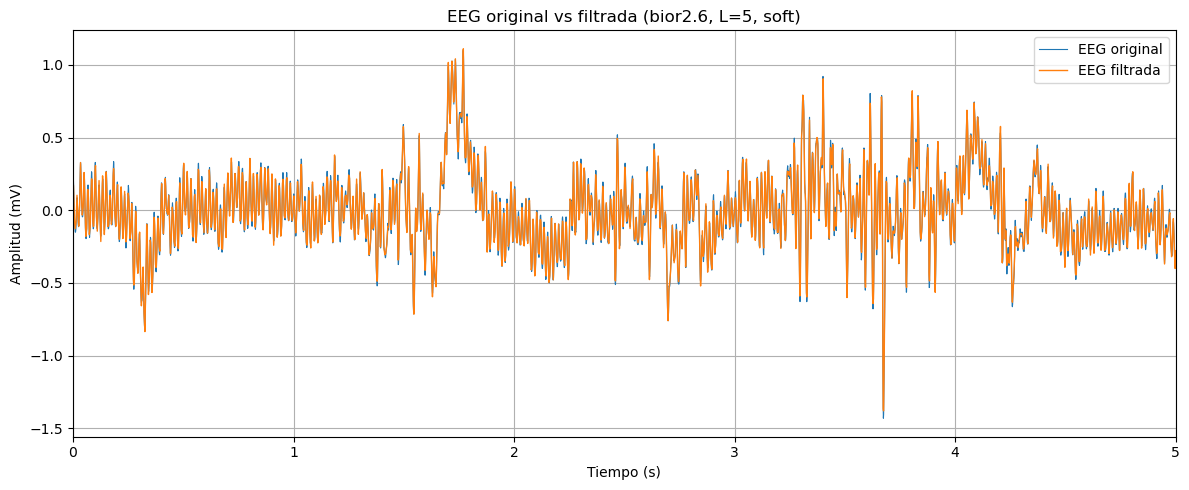

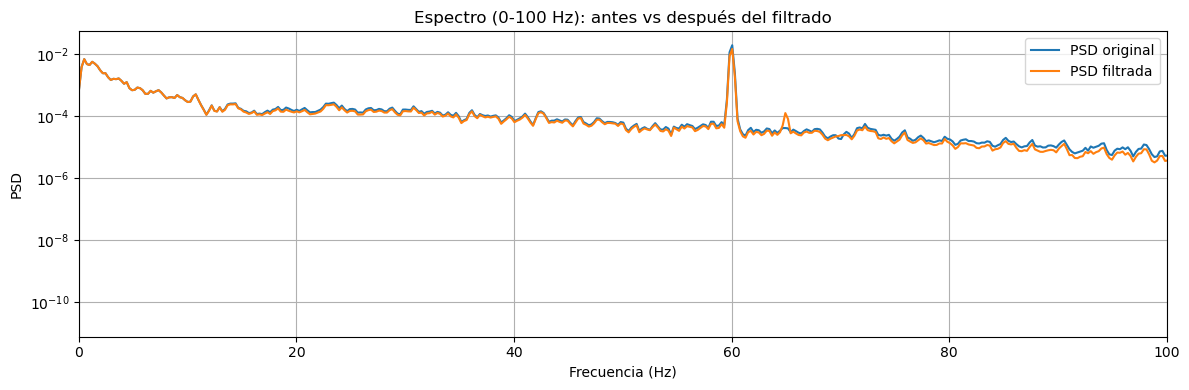

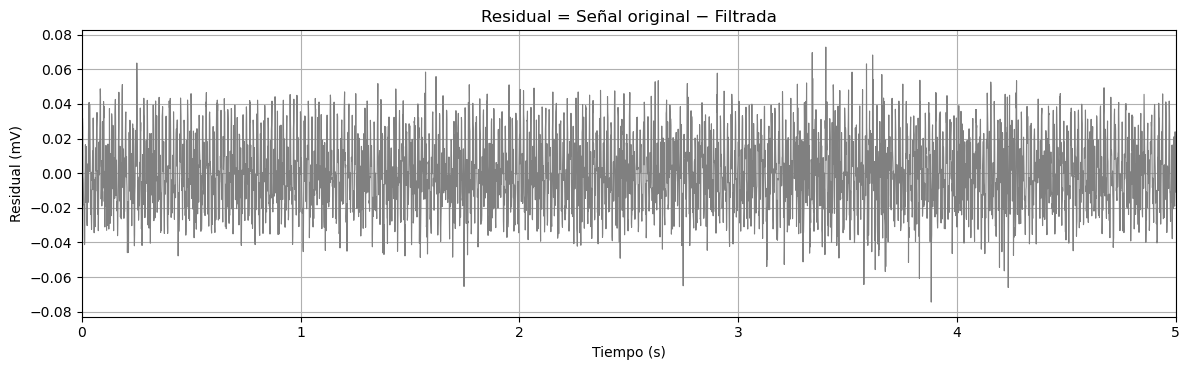

In [23]:
# ===========================
# CONFIGURACIÓN

RUTA       = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 5 - EEG\Registro de datos\T1_Resta.txt"
FS         = 1000.0      # Hz
CANAL_IDX  = 5           
WAVELET    = 'bior2.6'
LEVEL      = 5
TH_MODE    = 'soft'

# BITalino EEG
VCC, NBITS, GAIN = 3.3, 10, 1100.0

# ===========================
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks
from scipy.ndimage import median_filter
import pywt

# ===========================
# LECTURA Y CONVERSIÓN

arr = np.loadtxt(RUTA)
x_adc = arr[:, CANAL_IDX].astype(float)

adc_max = 2**NBITS
eeg_V = (x_adc/adc_max - 0.5) * (VCC/GAIN)
x = eeg_V*1000.0 - np.mean(eeg_V*1000.0)   # mV centrada
t = np.arange(len(x))/FS

# ===========================
# DWT FILTRADO Y RECONSTRUCCIÓN

coeffs = pywt.wavedec(x, WAVELET, level=LEVEL, mode='symmetric')
sigma  = np.median(np.abs(coeffs[-1]))/0.6745
lam    = sigma*np.sqrt(2*np.log(len(x)))

# umbralado suave en detalles
coeffs_filtradas = [coeffs[0]]
for c in coeffs[1:]:
    coeffs_filtradas.append(pywt.threshold(c, lam, mode=TH_MODE))

x_filt = pywt.waverec(coeffs_filtradas, WAVELET)[:len(x)]

# ===========================
# VERIFICACIÓN CUANTITATIVA

# --- SNR, RMSE, PRD, correlación ---
win = int(max(5, (0.2*FS)//1)) | 1
baseline = median_filter(x, size=win)
noise_before = x - baseline
residual = x - x_filt

SNR_before = 10*np.log10(np.sum(baseline**2)/np.sum(noise_before**2))
SNR_after  = 10*np.log10(np.sum(x_filt**2)/np.sum(residual**2))
SNR_gain   = SNR_after - SNR_before
RMSE = np.sqrt(np.mean(residual**2))
PRD  = 100*np.linalg.norm(residual)/np.linalg.norm(x)
corr = np.corrcoef(x, x_filt)[0,1]

print("=== MÉTRICAS DE VERIFICACIÓN ===")
print(f"SNR_before : {SNR_before:.2f} dB")
print(f"SNR_after  : {SNR_after:.2f} dB")
print(f"SNR_gain   : {SNR_gain:+.2f} dB")
print(f"RMSE       : {RMSE:.4f} mV")
print(f"PRD        : {PRD:.2f} %")
print(f"Corr(x,x_filt): {corr:.3f}")

# ===========================
# GRÁFICAS PARA VERIFICACIÓN

# 1. señal original vs filtrada
plt.figure(figsize=(12,5))
plt.plot(t, x, label='EEG original', lw=0.8)
plt.plot(t, x_filt, label='EEG filtrada', lw=1.0)
plt.xlim(0,5)
plt.xlabel('Tiempo (s)'); plt.ylabel('Amplitud (mV)')
plt.title(f'EEG original vs filtrada ({WAVELET}, L={LEVEL}, {TH_MODE})')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 2. PSD 0–100 Hz
f, Pxx_o = welch(x, fs=FS, nperseg=min(4096, len(x)))
_, Pxx_f = welch(x_filt, fs=FS, nperseg=min(4096, len(x_filt)))
plt.figure(figsize=(12,4))
plt.semilogy(f, Pxx_o, label='PSD original')
plt.semilogy(f, Pxx_f, label='PSD filtrada')
plt.xlim(0,100)
plt.xlabel('Frecuencia (Hz)'); plt.ylabel('PSD')
plt.title('Espectro (0-100 Hz): antes vs después del filtrado')
plt.legend(); plt.grid(True, which='both'); plt.tight_layout(); plt.show()

# 3. Residual (ruido removido)
plt.figure(figsize=(12,3.8))
plt.plot(t, residual, color='gray', lw=0.8)
plt.xlim(0,5)
plt.xlabel('Tiempo (s)'); plt.ylabel('Residual (mV)')
plt.title('Residual = Señal original − Filtrada')
plt.grid(True); plt.tight_layout(); plt.show()